<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/plant_pathology_chap7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier using [chap 7 of fastbook](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)

* no transfer learning ---> train from scratch
* use xresnet50 architecture
* use normalisation
* use progressive resizing
* use tta
* use mixup 
* use label smoothing
* train longer

In [ ]:
! pip uninstall fastai -y -q
! pip install fastai -q

     |████████████████████████████████| 194kB 9.5MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import fastai
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score

import pandas as pd
from tqdm.notebook import tqdm

# Hyperparameters, seeds, directories


In [ ]:
SEED=42
set_seed(SEED)
LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']
BS = 64
IMG_SIZE = 256
#ARCH = xresnet50

In [ ]:
DATA_DIR = Path('/content/gdrive/MyDrive/colab_notebooks/fastai/Plant Pathology/data')
IMG_DIR = Path('/content/gdrive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/images')

# Get Data

In [ ]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
test_df = pd.read_csv(DATA_DIR/'test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
train_df['label'] = train_df[LABELS].idxmax(axis=1)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [ ]:
def get_data(train_df, bs, img_size):
    
    datablock = DataBlock(
                blocks=(ImageBlock, CategoryBlock(vocab=LABELS)),
                getters=[
                ColReader('image_id', pref=IMG_DIR, suff='.jpg'),
                ColReader('label')
                ],
                splitter=RandomSplitter(valid_pct=0.33),
                item_tfms=Resize(img_size*2),
                batch_tfms=[*aug_transforms(size=img_size, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True), 
                            Normalize.from_stats(*imagenet_stats)]
                )
    return datablock.dataloaders(source=train_df, bs=bs)

In [ ]:
dls = get_data(train_df, BS, IMG_SIZE)

In [ ]:
dls.train.bs

64

In [ ]:
dls.valid.bs

64

In [ ]:
x,y = dls.one_batch()

In [ ]:
#not as close to mean=0 and std=1 ----> maybe apply mean and std from one_batch
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.3812,  0.3122, -0.4148], device='cuda:0'),
 TensorImage([0.8404, 0.7813, 0.7896], device='cuda:0'))

# Metrics

In [ ]:
def comp_metric(preds, targs, labels=range(len(LABELS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

# Learners

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, xresnet50, opt_func=opt_func,
                    loss_func=LabelSmoothingCrossEntropy(),             #label smoothing
                    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)],
                    cbs=MixUp()
                    ).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0004786300996784121)

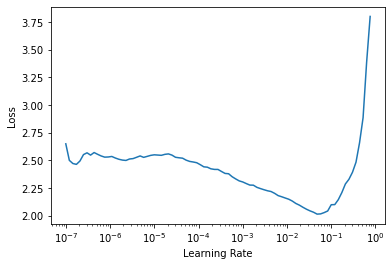

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.872091,0.767860,0.823333,0.821126,01:28
1,0.921000,0.826939,0.800000,0.846120,01:28
2,0.933232,0.826792,0.776667,0.840620,01:28
3,0.930396,0.776014,0.808333,0.860510,01:29
4,0.915372,0.691547,0.851667,0.876968,01:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.858202,0.686664,0.868333,0.870874,01:26
1,0.875487,0.808164,0.828333,0.846562,01:27
2,0.883585,0.723427,0.843333,0.869667,01:26
3,0.877768,0.691514,0.860000,0.878518,01:26
4,0.855948,0.650052,0.873333,0.886686,01:26


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.828894,0.668548,0.871667,0.885884,01:26
1,0.837771,0.655317,0.878333,0.885036,01:25
2,0.824558,0.707588,0.858333,0.872054,01:29
3,0.816995,0.635754,0.876667,0.888313,01:28
4,0.814240,0.624161,0.878333,0.887874,01:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.792411,0.644033,0.878333,0.899062,01:28
1,0.806785,0.656497,0.850000,0.874755,01:27
2,0.826299,0.636804,0.888333,0.861669,01:26
3,0.821141,0.617350,0.883333,0.896996,01:24
4,0.805810,0.621960,0.883333,0.904462,01:25


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.771962,0.633335,0.888333,0.887250,01:26
1,0.783894,0.616316,0.890000,0.871830,01:25
2,0.797131,0.654004,0.885000,0.876333,01:24
3,0.794707,0.598031,0.903333,0.901772,01:23
4,0.784501,0.583346,0.903333,0.902345,01:23


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.760802,0.603063,0.898333,0.885768,01:24
1,0.782270,0.669568,0.891667,0.853558,01:24
2,0.792069,0.589769,0.908333,0.895437,01:24
3,0.793857,0.589935,0.900000,0.891799,01:24
4,0.782564,0.579972,0.905000,0.893160,01:23


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.735240,0.609653,0.891667,0.908069,01:24
1,0.765048,0.623371,0.891667,0.882733,01:23
2,0.773520,0.587305,0.901667,0.918429,01:24
3,0.768781,0.586433,0.898333,0.925235,01:25
4,0.753100,0.575161,0.895000,0.923315,01:28


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.750537,0.567408,0.915000,0.929928,01:27
1,0.758882,0.633019,0.903333,0.893435,01:27
2,0.772583,0.606412,0.900000,0.919794,01:27
3,0.760207,0.558060,0.911667,0.922281,01:25
4,0.749473,0.552263,0.918333,0.929811,01:24


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.722941,0.579034,0.910000,0.919174,01:23
1,0.751042,0.592334,0.910000,0.914458,01:25
2,0.769568,0.586860,0.903333,0.912994,01:25
3,0.765482,0.559946,0.910000,0.921650,01:26
4,0.752510,0.558106,0.915000,0.923431,01:26


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.720466,0.580492,0.911667,0.916447,01:26
1,0.745464,0.567557,0.921667,0.930446,01:28
2,0.755331,0.609843,0.916667,0.934194,01:28
3,0.741833,0.554357,0.926667,0.938002,01:27
4,0.733000,0.548373,0.926667,0.933984,01:26


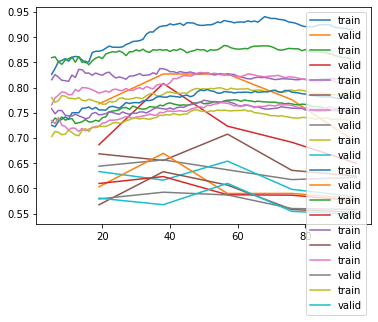

In [ ]:
for i in range(1, 11):
    learn.fit_one_cycle(5, 5e-3)
    learn.save(f'{DATA_DIR}/model/model_imgsz_{IMG_SIZE}_epoch_{50+5*i}')
    learn.recorder.plot_loss()

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.715657,0.555230,0.923333,0.945842,01:25
1,0.734577,0.637464,0.883333,0.941797,01:25
2,0.737988,0.571642,0.921667,0.938008,01:25
3,0.737349,0.564668,0.918333,0.939072,01:25
4,0.724517,0.549494,0.916667,0.942038,01:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.711199,0.541338,0.921667,0.927394,01:27
1,0.725910,0.574216,0.916667,0.938427,01:25
2,0.740254,0.570727,0.911667,0.927183,01:26
3,0.738693,0.531659,0.920000,0.937640,01:27
4,0.729975,0.533006,0.920000,0.939459,01:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.709507,0.542854,0.921667,0.946551,01:26
1,0.721965,0.557359,0.920000,0.941846,01:27
2,0.728886,0.554507,0.915000,0.946267,01:28
3,0.724096,0.553092,0.923333,0.951136,01:28
4,0.717100,0.540966,0.923333,0.950254,01:25


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.695783,0.576003,0.925000,0.936050,01:24
1,0.727856,0.580670,0.916667,0.936443,01:23
2,0.722955,0.560486,0.928333,0.941805,01:23
3,0.719440,0.535079,0.921667,0.950821,01:25
4,0.708584,0.534721,0.921667,0.950737,01:24


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.709690,0.550588,0.928333,0.943133,01:24
1,0.720904,0.549800,0.915000,0.945075,01:23
2,0.731165,0.579483,0.910000,0.933769,01:23
3,0.721993,0.540387,0.916667,0.943964,01:23
4,0.712153,0.539959,0.916667,0.945500,01:23


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.708257,0.526165,0.930000,0.948541,01:24
1,0.715965,0.553383,0.920000,0.937221,01:24
2,0.712009,0.561617,0.906667,0.936982,01:25
3,0.721239,0.517124,0.931667,0.958103,01:25
4,0.713885,0.516059,0.930000,0.961167,01:26


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.691157,0.517756,0.923333,0.957956,01:26
1,0.708669,0.547685,0.925000,0.948865,01:26
2,0.705766,0.541041,0.916667,0.950267,01:26
3,0.708865,0.530904,0.926667,0.952093,01:26
4,0.712206,0.520996,0.926667,0.958123,01:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.691611,0.546304,0.916667,0.953343,01:26
1,0.700644,0.566538,0.930000,0.950787,01:24
2,0.718780,0.543405,0.925000,0.928018,01:23
3,0.716833,0.520353,0.925000,0.956917,01:25
4,0.710968,0.519794,0.920000,0.956583,01:24


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.697412,0.531012,0.920000,0.950933,01:24
1,0.695487,0.522235,0.931667,0.957121,01:25
2,0.703626,0.520229,0.933333,0.945793,01:26
3,0.706026,0.532049,0.925000,0.951352,01:29
4,0.699285,0.521975,0.926667,0.950161,01:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.692031,0.525395,0.930000,0.944921,01:27
1,0.703111,0.548186,0.928333,0.938704,01:27
2,0.699147,0.506033,0.933333,0.965051,01:29
3,0.694609,0.510603,0.926667,0.962564,01:29
4,0.685771,0.502908,0.926667,0.963004,01:29


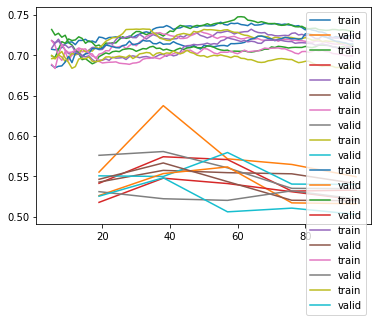

In [ ]:
for i in range(1, 11):
    learn.fit_one_cycle(5, 5e-3)
    learn.save(f'{DATA_DIR}/model/model_imgsz_{IMG_SIZE}_epoch_{100+5*i}')
    learn.recorder.plot_loss()

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.963316,1.004703,0.706667,0.819485,01:52


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.937306,0.833839,0.801667,0.858223,01:54
1,0.920934,0.712578,0.850000,0.870266,01:54
2,0.888780,0.657971,0.863333,0.885175,01:53


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.939865,1.724830,0.463333,0.657561,01:54
1,0.925271,0.593572,0.895000,0.836344,01:54
2,0.860819,0.556640,0.915000,0.882854,01:54


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.868931,0.650471,0.866667,0.836818,01:54
1,0.899711,0.594403,0.905000,0.805177,01:53
2,0.853682,0.540421,0.923333,0.851144,01:54


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.850690,0.736912,0.856667,0.804077,01:54
1,0.888629,0.563055,0.916667,0.844360,01:54
2,0.850263,0.540804,0.925000,0.863713,01:53


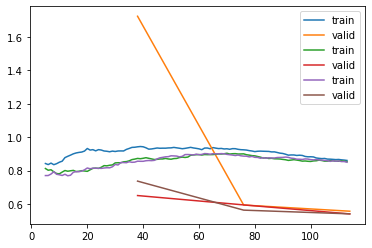

In [ ]:
learn.dls = get_data(train_df, 32, IMG_SIZE*2)
learn.fine_tune(3, 5e-3)

for i in range(1, 4):
    learn.fit_one_cycle(3, 5e-3)
    learn.save(f'{DATA_DIR}/model/model_imgsz_{IMG_SIZE*2}_epoch_{5*i}')
    learn.recorder.plot_loss()

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.873941,0.635880,0.900000,0.852641,03:03


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.884336,0.582893,0.911667,0.916915,03:28
1,0.858211,0.581566,0.921667,0.913675,03:27
2,0.817969,0.542186,0.920000,0.922498,03:25


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.001976,1.190599,0.616667,0.771981,03:26
1,1.000211,0.759017,0.831667,0.794139,03:25
2,0.910856,0.583181,0.898333,0.891907,03:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.940438,2.152034,0.246667,0.757557,03:25
1,0.958624,0.621887,0.896667,0.909121,03:25
2,0.876286,0.583187,0.911667,0.922269,03:27


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.921942,1.453305,0.556667,0.868886,03:26
1,0.905355,0.637730,0.875000,0.917781,03:26
2,0.870204,0.558893,0.913333,0.906568,03:25


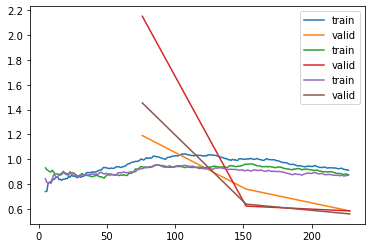

In [ ]:
learn.dls = get_data(train_df, 16, IMG_SIZE*4)
learn.fine_tune(3, 5e-3)

for i in range(1, 4):
    learn.fit_one_cycle(3, 5e-3)
    learn.save(f'{DATA_DIR}/model/model_imgsz_{IMG_SIZE*4}_epoch_{5*i}')
    learn.recorder.plot_loss()

In [ ]:
# lets test it on test df
test_dl = dls.test_dl(test_df)
learn.load(f'{DATA_DIR}/model/model_imgsz_{IMG_SIZE*2}_2')
test_preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{DATA_DIR}/submission_model_imgsz_{IMG_SIZE*2}_2_notta.csv', index=False)

In [ ]:
# preds with tta
preds,targs = learn.tta(dl=test_dl)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(preds, columns=LABELS)], axis=1)
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]
sub_df.to_csv(f'{DATA_DIR}/submission_model_imgsz_{IMG_SIZE*2}_2_tta.csv', index=False)